# Lesson 2 : LangGraph Components

In [1]:
# Install specific versions of packages
#!pip install langgraph==0.0.53 langchain-core==0.2.0 langchain-openai==0.1.7 langchain-community==0.2.0 pygraphviz==1.13 ipython==8.18.1




There is a more standard langchain agent prompt here:

```python
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain import hub
prompt = hub.pull("hwchase17/react")
```

```markdown
Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}
```


In [18]:
from dotenv import load_dotenv

_ = load_dotenv()

In [20]:
from langgraph.graph import StateGraph, END #  
from typing import TypedDict, Annotated # these are used to construct the agent state
import operator  
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage # these are langchain emssage types to represent human / ai / system messages
from langchain_openai import ChatOpenAI # langchain wrapper aroudn teh api
from langchain_community.tools.tavily_search import TavilySearchResults # the tool

In [21]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [22]:
class AgentState(TypedDict):
    # this annotated stuff means that when we go to overwrite it we instead add to the end
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [25]:
class Agent:

    def __init__(self, model, tools, system=""): # system is the system prompt
        self.system = system
        graph = StateGraph(AgentState) #  initialise the graph with AgentState
        
        # now we are just creating places for the actuall 'stuff' to go - we are sketching the graph
        graph.add_node("llm_decide", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm_decide",
            self.exists_action,
            {True: "action", False: END} # we imported END at the beginning - this tells langgraph we are done
        )
        graph.add_edge("action", "llm_decide") # this creates an edge from action to llm_decide to complete the loop
        graph.set_entry_point("llm_decide") # and this tells us where we start
        
        self.graph = graph.compile() # this is what we call after all the set ups and creates the graph
        self.tools = {t.name: t for t in tools} # save the tools - mapping name to the tool itself
        self.model = model.bind_tools(tools) # save the models -  we are passing in the list of tools - it lets model know it has these tools available


    def call_openai(self, state: AgentState): # all nodes and edges take the AgentState in as a parameter
        messages = state['messages'] # we'll grab the messages
        if self.system:  # then we'll add the system state which defines the Agent's rules and we'll call the LLM 
            # This checks ⬆️ if there is a system message. If so we insert it at the start before we do the message history.
            messages = [SystemMessage(content=self.system)] + messages # <- it puts the system prompt at the start
        # this sends the entire history to the LLM - starting with system and then the chatter.
        message = self.model.invoke(messages) 
        return {'messages': [message]} # it's a dictionary - but the dict only has one message - the message returned from the llm - because of annotate we don't overwrite the agentstate we just add to it
    

    def take_action(self, state: AgentState):
        # IF we get into this state, it's because we KNOW that we want to call a tool
        # so this line here grabs the tool calls from the most recent message in the state
        # we know it's in there cos we got here
        # it could be a list of tool calls which allows parallel tool calling
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad  - this string is sent back as the "observation" so it'll see it and hopefully try again
            else:
                result = self.tools[t['name']].invoke(t['args'])
            # because we might call multiple tools, we have to add each result to a collection of results.
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
            #print (f"Appending ToolMessage(tool_call_id = {t['id']}, name={t['name']}, content={str(result)}")
        print("Back to the model! We have passed back all the new messages.")
        return {'messages': results}



    def exists_action(self, state: AgentState):
        # This is the conditional node.
        # It returns True of False depending on whether there are tools or not.
        # So we grab the latest message and if it has  ANY tool_calls it's true
        # Question for later - if take_action adds more than one thing to the messages will the older get lost? 
        # answer no - because we only ever return one message from LLM - then we go here and from HERE we go to take action - in take action you see results.append - that is what allows multiple tool answers in one loop
        result = state['messages'][-1]
        return len(result.tool_calls) > 0


In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

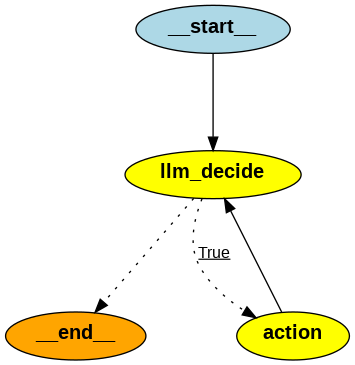

In [8]:
from IPython.display import Image
# abot is our Agent  - we grab the graph object, get the graph from it and draw we can see our flow
Image(abot.graph.get_graph().draw_png())

In [34]:
messages = [HumanMessage(content="what is the latest on Michael Stipe's solo album?")]
result = abot.graph.invoke({"messages": messages})  # the AgentState is built on messages - so you can't just invoke with a string, you have to send a dictionary with a messages list item

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Michael Stipe latest solo album news 2023'}, 'id': 'call_93XnuixXvgQIqz4GXH8Q8AVg'}
Back to the model! We have passed back all the new messages.


In [32]:
result # this is the final state of the agent

{'messages': [HumanMessage(content="what is the latest on Michael Stipe's solo album?"),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_adRu6Frz136AB0B7Wr4iihQ9', 'function': {'arguments': '{"query":"latest news on Michael Stipe\'s solo album 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 156, 'total_tokens': 185}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_319be4768e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7995e826-f7f5-45f2-a57d-7f75bf234c9c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': "latest news on Michael Stipe's solo album 2023"}, 'id': 'call_adRu6Frz136AB0B7Wr4iihQ9'}]),
  ToolMessage(content='[{\'url\': \'https://www.nytimes.com/2023/12/03/magazine/michael-stipe-solo-album.html\', \'content\': \'It was an unusual experience: being Michael Stipe, being in R.E.M., selling some 90 million albums, tourin

In [33]:
result['messages'][-1].content # and this is the last message

'Michael Stipe, the former R.E.M. frontman, has been working on his first solo album and is set to release it in 2023. Here are a few key points from the latest updates:\n\n1. **Rolling Stone Interview**: In a recent interview with Rolling Stone, Michael Stipe mentioned that he is slowly but surely working on his solo album. This is his first solo project after a long career with R.E.M. [Read more](https://www.rollingstone.com/music/music-news/michael-stipe-solo-album-interview-1234908779/).\n\n2. **American Songwriter**: Stipe confirmed that the album is indeed in progress and set for a 2023 release. This will mark his debut solo album after the disbandment of R.E.M. [Read more](https://americansongwriter.com/michael-stipe-set-to-release-first-solo-album-in-2023/).\n\n3. **Ultimate Classic Rock**: Additional insights reveal that Stipe has already released a debut single, "Your Capricious Soul," as part of this new venture. [Read more](https://ultimateclassicrock.com/michael-stipe-solo

In [37]:
messages = [HumanMessage(content="What are the 10 most common problems people have when they use intellij for python in windows, but running under wsl - and for each of thise what is a common workaround? it is important to have a 1-1 ordered list of problem / solution")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'common problems using IntelliJ for Python in Windows with WSL'}, 'id': 'call_adRu6Frz136AB0B7Wr4iihQ9'}
Back to the model! We have passed back all the new messages.
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'common issues with IntelliJ Python setup in WSL'}, 'id': 'call_ordZb1fMkTcmEMP543qvVdeM'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'workarounds for IntelliJ Python issues in WSL'}, 'id': 'call_56oOUlovrWmR6lDm09h44knc'}
Back to the model! We have passed back all the new messages.


In [38]:
result['messages'][-1].content

'Based on the information gathered, here are ten common problems people face when using IntelliJ for Python in Windows with WSL, along with common workarounds for each:\n\n1. **Problem: Performance Issues**\n   - **Solution:** Store all project files under the `\\\\wsl$` folder of your distro instead of the Windows side to reduce performance drawbacks. This improves file access speed.\n\n2. **Problem: IntelliJ Blocks in Firewall**\n   - **Solution:** If IntelliJ appears blocked in the firewall settings, enable the connection by selecting the rule, choosing Properties, and then selecting "Allow the connection." Restart IntelliJ after making these changes.\n\n3. **Problem: Compiler Ignores Changes**\n   - **Solution:** Ensure the project directory in WSL is added as an exclusion in Windows Defender to prevent it from ignoring recent changes.\n\n4. **Problem: Slow Debugger Performance**\n   - **Solution:** Allocate more RAM to the WSL2 instance to improve performance. For example, assign 

In [15]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_8Bbhkatl0gPyrIo2cMXOtuY4'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current GDP of the US states 2024'}, 'id': 'call_VI5eyF793w1CTcI6O6nbStZx'}
Back to the model! We have passed back all the new messages.


In [16]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**
   - The Kansas City Chiefs won the Super Bowl in 2024, beating the San Francisco 49ers 25-22 in overtime.

2. **In what state is the winning team's headquarters located?**
   - The Kansas City Chiefs are headquartered in Kansas City, Missouri.

3. **What is the GDP of that state?**
   - For the most recent data, Missouri's GDP can be found on the Bureau of Economic Analysis website, which reports GDP by state. The GDP of Missouri for the year 2023 was not specifically listed, but the data shows varied growth rates across states, with Missouri's GDP growth being in line with national trends. The exact GDP for Missouri in the first quarter of 2024 is not explicitly mentioned in the initial search results.


In [17]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "What were the GDPs of Missouri and the United Kingdom over the last decade.  Which had a greater GDP and by how much?  What was the annual turnover of the highest earning company in that same perios.  Now create an ordered rank of each, ordered highest to lowest.  Answer all questions.  Use billions of USD" 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

print ("***** Final*****\n")
print(result['messages'][-1].content)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP last decade'}, 'id': 'call_JWqfL4WZsUrrjCHmPaqssRsj'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'United Kingdom GDP last decade'}, 'id': 'call_iqIGWvZeQXbfw1EHTnFMA0sr'}
Back to the model! We have passed back all the new messages.
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'highest earning company annual turnover last decade'}, 'id': 'call_wmwtBLUrElmZJyEzNiAEGVa0'}
Back to the model! We have passed back all the new messages.
***** Final*****

### Highest Earning Company (Annual Turnover)
- **Walmart** has consistently been the world's largest company by revenue since 2014 according to sources like Fortune and Wikipedia.
- Walmart's annual revenue has been over $500 billion in recent years.

Now let's summarize the relevant information:

### GDP of Missouri and the United Kingdom (Last Decade)
- **Missouri:** $336.63 billion (2022)
- **United Kingdom:** Varied 